In [12]:
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from utils.steady_state import find_steady_state
import tempfile
import subprocess

Dataset: Baseline

In [7]:
# Setup Configuration
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-26-IY020/data")
RESULTS_PATH = DATA_ROOT / "IY020_simulation_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
print(f"Total number of trajectories simulated: {len(df_params)}")
# filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
df_params = df_params[(df_params['success'] == True) & 
                    (df_params['error_message'].isna()) &
                    (df_params['mean_rel_error_pct'] < 10) & 
                    (df_params['cv_rel_error_pct'] < 10) & 
                    (df_params['t_ac_rel_error_pct'] < 10)]
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]

print(f"Number of VALID trajectories: {len(TRAJ_PATH)}")

Total number of trajectories simulated: 10000
Number of VALID trajectories: 7709


Dataset: Mu Variation

In [8]:
# Setup Configuration
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-26-IY020/data_mu_variation")
RESULTS_PATH = DATA_ROOT / "IY020_simulation_mu_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
print(f"Total number of trajectories simulated: {len(df_params)}")
# filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
df_params = df_params[(df_params['success'] == True) & 
                    (df_params['error_message'].isna()) &
                    (df_params['mean_rel_error_pct'] < 10) & 
                    (df_params['cv_rel_error_pct'] < 10) & 
                    (df_params['t_ac_rel_error_pct'] < 10)]
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]
print(f"Number of VALID trajectories: {len(TRAJ_PATH)}")

Total number of trajectories simulated: 10000
Number of VALID trajectories: 9997



=== Starting Data Processing for ML ===
Calculating steady state indices for alignment...
Max steady state index determined: 97
Processing 9997 files into .npz format...


Saving NPZs: 100%|██████████| 9997/9997 [55:46<00:00,  2.99it/s]  


Data processing complete.


PermissionError: [Errno 13] Permission denied: 'data_mu_variation/IY020_mu_target_vs_mu_observed.png'

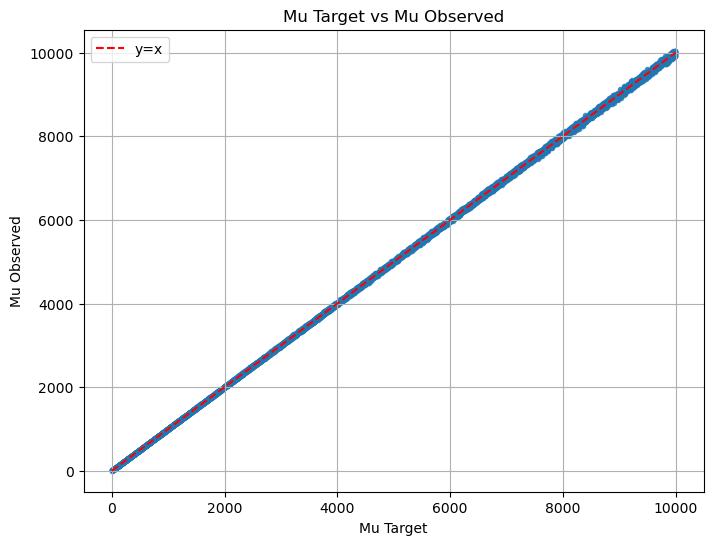

In [ ]:
data_dir = "data_mu_variation"
results_path = os.path.join(data_dir, "IY020_simulation_mu_parameters_sobol.csv")
time_points = np.arange(0, 3000, 1.0)
# -----------------------------------------------------------------------------
# Data Processing for Machine Learning (Post-Simulation): Steady State Extraction, NPZ Saving
# -----------------------------------------------------------------------------
print("\n=== Starting Data Processing for ML ===")

# Define paths using the existing configuration variables
# Ensure DATA_ROOT uses the same 'data_dir' defined at the top of your script
DATA_ROOT = Path(data_dir) 
# Use the results_path defined earlier in your script
RESULTS_PATH = Path(results_path) 

if not RESULTS_PATH.exists():
    print(f"Warning: Results file not found at {RESULTS_PATH}. Skipping processing.")
else:
    df_params = pd.read_csv(RESULTS_PATH)
    #filter for successful simulations only
    # df_params = df_params[df_params["success"] == True].dropna(subset=["trajectory_filename"])
    df_params = df_params[(df_params['success'] == True) & 
                    (df_params['error_message'].isna()) &
                    (df_params['mean_rel_error_pct'] < 10) & 
                    (df_params['cv_rel_error_pct'] < 10) & 
                    (df_params['t_ac_rel_error_pct'] < 10)]
    
    # Reconstruct the list of file paths and parameter sets from the CSV
    # This ensures we process exactly what was just simulated
    traj_paths = [DATA_ROOT / str(fname) for fname in df_params['trajectory_filename']]
    
    # Rebuild the parameter_sets list needed for find_steady_state
    # Structure: List of [ { "sigma_b": ..., "rho": ... } ]
    parameter_sets = []
    for _, row in df_params.iterrows():
        p_set = [{
            "sigma_b": row['sigma_b'],
            "sigma_u": row['sigma_u'],
            "rho": row['rho'],
            "d": row['d'],
            "label": 0
        }]
        parameter_sets.append(p_set)

    # --- Step 1: Calculate Steady State Indices ---
    print("Calculating steady state indices for alignment...")
    ss_index_list = []
    for params in parameter_sets:
        # find_steady_state returns (distribution, index)
        _, ss_index = find_steady_state(params[0])
        ss_index_list.append(ss_index)

    # Find the maximum steady state index to cut all trajectories to the same length
    if ss_index_list:
        max_ss_index = max(ss_index_list)
        print(f"Max steady state index determined: {max_ss_index}")
        
        # Calculate the new time points vector corresponding to the sliced data
        # 'time_points' is the global variable defined in your configuration section
        new_time_points = time_points[max_ss_index:]
        
        # --- Step 2: Slice and Save as NPZ ---
        print(f"Processing {len(traj_paths)} files into .npz format...")
        
        for traj_file, params in tqdm(zip(traj_paths, parameter_sets), total=len(traj_paths), desc="Saving NPZs"):
            if not traj_file.exists():
                continue
                
            try:
                # Load the raw CSV trajectory data
                df_traj = pd.read_csv(traj_file)
                
                # Remove label column if present
                df_traj = df_traj.drop(columns=['label'], errors='ignore')
                
                # Truncate to the maximum steady state start time
                # This ensures all ML inputs have the same sequence length
                if max_ss_index < df_traj.shape[1]:
                    df_traj = df_traj.iloc[:, max_ss_index:]
                
                trajectories = df_traj.values.astype(np.float32)
                
                # Prepare dictionary for NPZ
                trajectory_data = {
                    'trajectories': trajectories,
                    'time_points': new_time_points.astype(np.float32),
                    'size': int(trajectories.shape[0]),
                    'parameters': params,
                }
                
                # Save compressed NPZ
                npz_path = traj_file.with_suffix('.npz')
                try:
                    np.savez_compressed(npz_path, **trajectory_data)
                except PermissionError:
                    # Handle permissions if running in a restricted environment
                    with tempfile.NamedTemporaryFile(delete=False, suffix='.npz') as tmp_file:
                        tmp_path = tmp_file.name
                        np.savez_compressed(tmp_path, **trajectory_data)
                    
                    # Move temp file to final location with sudo
                    subprocess.run(['sudo', 'mv', tmp_path, str(npz_path)], check=True)
                    subprocess.run(['sudo', 'chown', f'{os.getenv("USER")}:{os.getenv("USER")}', str(npz_path)], check=True)
                    
            except Exception as e:
                print(f"Error processing {traj_file.name}: {e}")

    print("Data processing complete.")


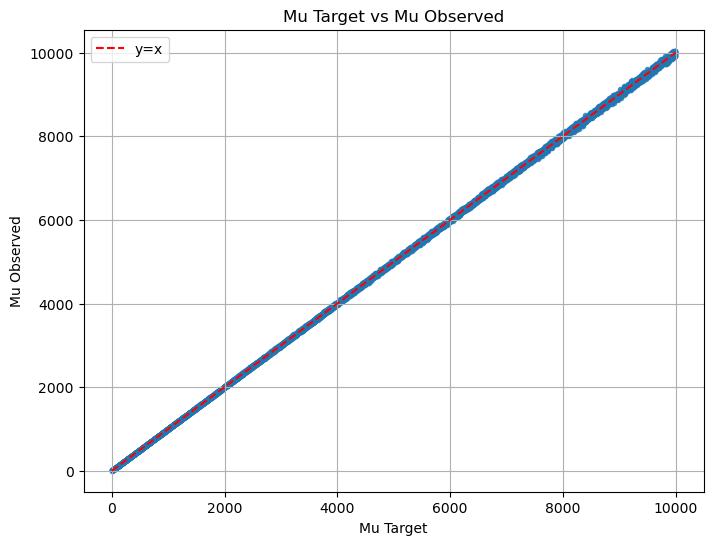

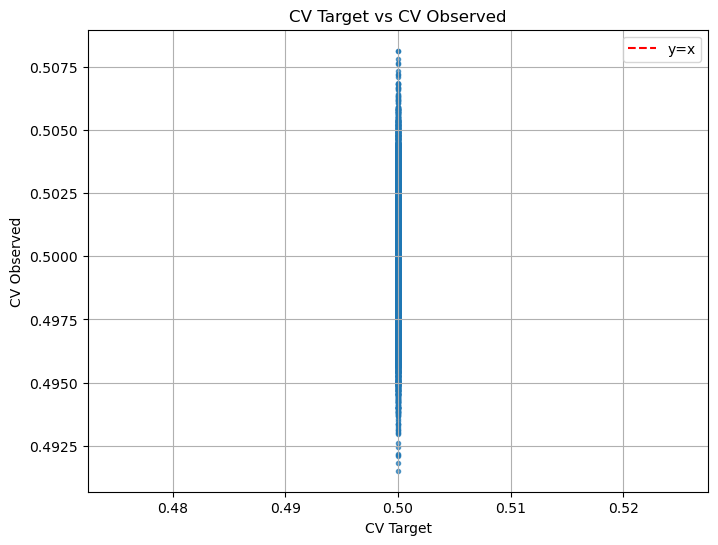

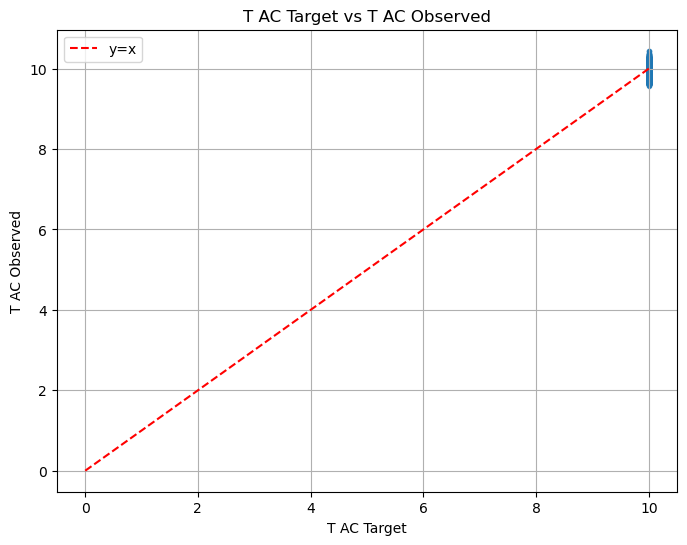

In [15]:
import matplotlib.pyplot as plt
df_params = pd.read_csv(RESULTS_PATH)

#plot mu_target vs mu_observed
plt.figure(figsize=(8, 6))
plt.scatter(df_params['mu_target'], df_params['mu_observed'], alpha=0.7, marker='.')
plt.plot([0, df_params['mu_target'].max()],
         [0, df_params['mu_target'].max()], 'r--', label='y=x')
plt.xlabel('Mu Target')
plt.ylabel('Mu Observed')
plt.title('Mu Target vs Mu Observed')
plt.legend()
plt.grid(True)
plt.savefig(f'./IY020_mu_target_vs_mu_observed.png', dpi=300)
plt.show()

# plot cv_target vs cv_observed
plt.figure(figsize=(8, 6))
plt.scatter(df_params['cv_target'], df_params['cv_observed'], alpha=0.7, marker='.')
plt.plot([df_params['cv_target'].min(), df_params['cv_target'].max()],
         [df_params['cv_target'].min(), df_params['cv_target'].max()], 'r--', label='y=x')
plt.xlabel('CV Target')
plt.ylabel('CV Observed')
plt.title('CV Target vs CV Observed')
plt.legend()
plt.grid(True)
plt.savefig(f'./IY020_cv_target_vs_cv_observed.png', dpi=300)
plt.show()

# plot t_ac_target vs t_ac_observed
plt.figure(figsize=(8, 6))
plt.scatter(df_params['t_ac_target'], df_params['t_ac_observed'], alpha=0.7, marker='.')
plt.plot([0, df_params['t_ac_target'].max()],
         [0, df_params['t_ac_target'].max()], 'r--', label='y=x')
plt.xlabel('T AC Target')
plt.ylabel('T AC Observed')
plt.title('T AC Target vs T AC Observed')
plt.legend()
plt.grid(True)
plt.savefig(f'./IY020_t_ac_target_vs_t_ac_observed.png', dpi=300)
plt.show()

CV Variation Dataset

In [9]:
# Setup Configuration
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-26-IY020/data_cv_variation")
RESULTS_PATH = DATA_ROOT / "IY020_simulation_cv_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
print(f"Total number of trajectories simulated: {len(df_params)}")
# filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
df_params = df_params[(df_params['success'] == True) & 
                    (df_params['error_message'].isna()) &
                    (df_params['mean_rel_error_pct'] < 10) & 
                    (df_params['cv_rel_error_pct'] < 10) & 
                    (df_params['t_ac_rel_error_pct'] < 10)]
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]
print(f"Number of VALID trajectories: {len(TRAJ_PATH)}")

Total number of trajectories simulated: 10000
Number of VALID trajectories: 9699


Dataset: t-ac Variation

In [10]:
# Setup Configuration
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-26-IY020/data_t_ac_variation")
RESULTS_PATH = DATA_ROOT / "IY020_simulation_t_ac_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
print(f"Total number of trajectories simulated: {len(df_params)}")
# filter out only successful simulations with no error_message, and mean_rel_error_pct < 10, cv_rel_error_pct  < 10, & t_ac_rel_error_pct < 10
df_params = df_params[(df_params['success'] == True) & 
                    (df_params['error_message'].isna()) &
                    (df_params['mean_rel_error_pct'] < 10) & 
                    (df_params['cv_rel_error_pct'] < 10) & 
                    (df_params['t_ac_rel_error_pct'] < 10)]
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]
print(f"Number of VALID trajectories: {len(TRAJ_PATH)}")

Total number of trajectories simulated: 10000
Number of VALID trajectories: 9660
